In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')

import csv
import numpy as np
import pandas as pd
import scipy.io
from spykes.neurovis import NeuroVis
from spykes.popvis import PopVis

# Neuropixels

Neuropixels is a new recording technique by [UCL](https://www.ucl.ac.uk/cortexlab/neuropixels) that is able to measure data from from hundreds of neurons. Below we show how this data can be worked with in Spykes.

### 0. Download Data

Download all data [here](http://data.cortexlab.net/dualPhase3/data/). 

We use the files:
    
    timeCorrection.npy
    experiment1stimInfo.mat
    frontal/
        spike_clusters.npy
        spike_times.npy
        cluster_groups.csv
    posterior/
        spike_clusters.npy
        spike_times.npy
        cluster_groups.csv

### 1. Read In Data

In [2]:
folderNames = ['posterior', 'frontal']
popList = list()
Fs = 30000.0

for name in folderNames:
    
    clusters = np.squeeze(np.load(name + '/spike_clusters.npy'))
    
    spikeTimes = (np.squeeze(np.load(name + '/spike_times.npy')))/Fs
    
    # frontal times need to align with posterior
    if (name == 'frontal'):
        timeCorrection = np.load('timeCorrection.npy')
        spikeTimes *= timeCorrection[0] 
        spikeTimes += timeCorrection[1]
    
    data = np.recfromcsv(name + '/cluster_groups.csv', delimiter = '\t')
    cids = np.array([x[0] for x in data])
    cfg = np.array([x[1] for x in data])
    
    
    # find good clusters and only use those spikes
    goodClusters = cids[cfg == 'good']
    goodIndices = (np.in1d(clusters, goodClusters))
        
    realSpikes = spikeTimes[goodIndices]
    realClusters = clusters[goodIndices]
    
    # find how many spikes per cluster and then order spikes by which cluster they are in
    
    countsPerCluster = np.bincount(realClusters)
    
    sort_idx = np.argsort(realClusters) 
    sortedClusters = realClusters[sort_idx]
    sortedSpikes = spikeTimes[sort_idx]
    
    # create neurons
            
    allNeurons = list()
    
    accumulator = 0
    for i, count in enumerate(countsPerCluster):
        if count > 0:
            spiketimes = sortedSpikes[accumulator:accumulator+count]
            allNeurons.append(NeuroVis(spiketimes=spiketimes, name='%d' % (i)))
            accumulator += count
    
    # create PopVis objects
    # lets just look at the first ten for simplicity's sake
    popList.append(PopVis(allNeurons[:10])) 


### 2. Create Data Frame

In [3]:
df = pd.DataFrame()

rawData = scipy.io.loadmat('experiment1stimInfo.mat')

df['start'] = np.squeeze(rawData['stimStarts'])
df['stop'] = np.squeeze(rawData['stimStops'])
df['stimulus'] = np.squeeze(rawData['stimIDs'])

print df.head()

        start        stop  stimulus
0   99.108333  101.108333         6
1  101.908333  103.908333         3
2  104.924667  106.924667        11
3  107.574667  109.574667         7
4  110.308000  112.308000         8


### 3. Start Plotting

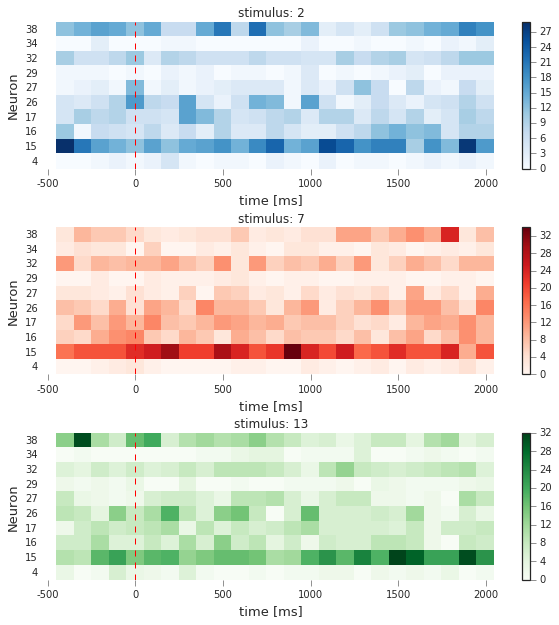

In [4]:
pop = popList[0] # we'll just look at the first PopVis object for the example

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.4)

all_psth = pop.get_all_psth(event='start', df=df, conditions='stimulus', plot=False, binsize=100, window = [-500, 2000])

pop.plot_heat_map(all_psth, cond_id=[2, 7, 13]) # cond_id chosen randomly

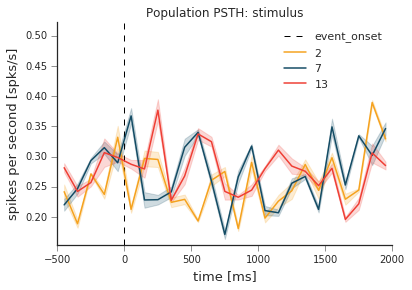

In [5]:
pop.plot_population_psth(all_psth=all_psth, cond_id=[2, 7, 13])